In [1]:
import config
import dr_methods as drm
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.transforms as tr
import niftiutils.visualization as vis
import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from os.path import *
import pandas as pd
import shutil
import re
import random
import seg_methods as sm
import time
import voi_methods as vm
import operator
%matplotlib inline
import scipy.stats
import math
import scipy.misc

import manifold as mani
import keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from skimage.morphology import ball
import seaborn as sns
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config
import tensorflow as tf
from keras import backend as K

import cnn_builder as cbuild
import cnn_runner as crun
os.environ["CUDA_VISIBLE_DEVICES"]="2"
c = tf.ConfigProto()
c.gpu_options.allow_growth=True
sess = tf.Session(config=c)
K.set_session(sess)

sns.set(style="ticks")
%matplotlib inline

Using TensorFlow backend.


In [4]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
importlib.reload(crun)
C = config.Config()
T = config.Hyperparams()
T.get_best_hyperparams(C.dataset)
R = crun.CNNRunner(C,T)

In [5]:
R.run_fixed_hyperparams(max_runs=10, model_name='std_', verbose=True)

Epoch 1/350
256/256 [==============================] - 29s 115ms/step - loss: 1.5949 - acc: 0.4380 - val_loss: 1.0992 - val_acc: 0.5667
Epoch 2/350
256/256 [==============================] - 20s 79ms/step - loss: 1.2363 - acc: 0.5669 - val_loss: 0.9016 - val_acc: 0.6667
Epoch 3/350
256/256 [==============================] - 21s 80ms/step - loss: 1.1078 - acc: 0.6201 - val_loss: 0.7201 - val_acc: 0.6333
Epoch 4/350
256/256 [==============================] - 20s 80ms/step - loss: 1.0273 - acc: 0.6621 - val_loss: 0.6660 - val_acc: 0.6333
Epoch 5/350
256/256 [==============================] - 21s 81ms/step - loss: 0.9547 - acc: 0.6872 - val_loss: 0.6554 - val_acc: 0.7333
Epoch 6/350
256/256 [==============================] - 21s 81ms/step - loss: 0.9242 - acc: 0.7070 - val_loss: 0.6127 - val_acc: 0.8333
Epoch 7/350
256/256 [==============================] - 21s 81ms/step - loss: 0.9026 - acc: 0.7082 - val_loss: 0.5403 - val_acc: 0.8000
Epoch 8/350
256/256 [==============================] -

256/256 [==============================] - 21s 80ms/step - loss: 0.3675 - acc: 0.9146 - val_loss: 0.7778 - val_acc: 0.8333
Epoch 62/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3459 - acc: 0.9235 - val_loss: 0.8185 - val_acc: 0.8333
Epoch 63/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3661 - acc: 0.9170 - val_loss: 0.7151 - val_acc: 0.8000
Epoch 64/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3623 - acc: 0.9189 - val_loss: 0.6170 - val_acc: 0.8000
Epoch 65/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3476 - acc: 0.9202 - val_loss: 0.7312 - val_acc: 0.8333
Epoch 66/350
256/256 [==============================] - 20s 79ms/step - loss: 0.3473 - acc: 0.9240 - val_loss: 0.5958 - val_acc: 0.8667
Epoch 67/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3416 - acc: 0.9248 - val_loss: 0.6529 - val_acc: 0.8333
Epoch 68/350
256/256 [==============================] - 21s 8

256/256 [==============================] - 20s 79ms/step - loss: 0.2699 - acc: 0.9468 - val_loss: 0.5850 - val_acc: 0.8333
Epoch 122/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2757 - acc: 0.9463 - val_loss: 0.5575 - val_acc: 0.8333
Epoch 123/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2691 - acc: 0.9445 - val_loss: 0.7624 - val_acc: 0.8667
Epoch 124/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2519 - acc: 0.9544 - val_loss: 0.6810 - val_acc: 0.8000
Epoch 125/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2628 - acc: 0.9495 - val_loss: 0.6889 - val_acc: 0.8667
Epoch 126/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2587 - acc: 0.9528 - val_loss: 0.6245 - val_acc: 0.8667
Epoch 127/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2602 - acc: 0.9504 - val_loss: 0.6127 - val_acc: 0.8000
Epoch 128/350
256/256 [==============================] 

256/256 [==============================] - 20s 79ms/step - loss: 0.2279 - acc: 0.9574 - val_loss: 0.6900 - val_acc: 0.8333
Epoch 181/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2204 - acc: 0.9590 - val_loss: 0.6322 - val_acc: 0.8667
Epoch 182/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2217 - acc: 0.9590 - val_loss: 0.6392 - val_acc: 0.8667
Epoch 183/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2271 - acc: 0.9557 - val_loss: 0.6528 - val_acc: 0.8333
Epoch 184/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2232 - acc: 0.9595 - val_loss: 0.7736 - val_acc: 0.8000
Epoch 185/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2230 - acc: 0.9591 - val_loss: 0.6361 - val_acc: 0.8333
Epoch 186/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2221 - acc: 0.9611 - val_loss: 0.5863 - val_acc: 0.8667
Epoch 187/350
256/256 [==============================] 

Epoch 240/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1964 - acc: 0.9663 - val_loss: 0.7491 - val_acc: 0.8667
Epoch 241/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2137 - acc: 0.9587 - val_loss: 0.7329 - val_acc: 0.8667
Epoch 242/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1986 - acc: 0.9663 - val_loss: 0.6323 - val_acc: 0.8667
Epoch 243/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1979 - acc: 0.9652 - val_loss: 0.6215 - val_acc: 0.8667
Epoch 244/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2106 - acc: 0.9583 - val_loss: 0.7774 - val_acc: 0.8333
Epoch 245/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2021 - acc: 0.9626 - val_loss: 0.8132 - val_acc: 0.8667
Epoch 246/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1912 - acc: 0.9681 - val_loss: 0.8949 - val_acc: 0.8333
Epoch 247/350
256/256 [==================

Epoch 300/350
256/256 [==============================] - 20s 79ms/step - loss: 0.1867 - acc: 0.9710 - val_loss: 0.8039 - val_acc: 0.8333
Epoch 301/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1829 - acc: 0.9671 - val_loss: 0.6600 - val_acc: 0.9000
Epoch 302/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1827 - acc: 0.9701 - val_loss: 0.7543 - val_acc: 0.9000
Epoch 303/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1857 - acc: 0.9673 - val_loss: 0.7183 - val_acc: 0.9000
Epoch 304/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1852 - acc: 0.9668 - val_loss: 0.7951 - val_acc: 0.9000
Epoch 305/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1809 - acc: 0.9696 - val_loss: 0.8492 - val_acc: 0.8333
Epoch 306/350
256/256 [==============================] - 20s 79ms/step - loss: 0.1914 - acc: 0.9666 - val_loss: 0.7601 - val_acc: 0.8333
Epoch 307/350
256/256 [==================

Epoch 23/350
256/256 [==============================] - 21s 81ms/step - loss: 0.5363 - acc: 0.8564 - val_loss: 0.4814 - val_acc: 0.8333
Epoch 24/350
256/256 [==============================] - 20s 80ms/step - loss: 0.5205 - acc: 0.8626 - val_loss: 0.4946 - val_acc: 0.8333
Epoch 25/350
256/256 [==============================] - 20s 79ms/step - loss: 0.5311 - acc: 0.8576 - val_loss: 0.4130 - val_acc: 0.9000
Epoch 26/350
256/256 [==============================] - 21s 81ms/step - loss: 0.5089 - acc: 0.8621 - val_loss: 0.3351 - val_acc: 0.8667
Epoch 27/350
256/256 [==============================] - 20s 80ms/step - loss: 0.5069 - acc: 0.8670 - val_loss: 0.4185 - val_acc: 0.9000
Epoch 28/350
256/256 [==============================] - 20s 80ms/step - loss: 0.4933 - acc: 0.8706 - val_loss: 0.4700 - val_acc: 0.8333
Epoch 29/350
256/256 [==============================] - 20s 80ms/step - loss: 0.4820 - acc: 0.8763 - val_loss: 0.3728 - val_acc: 0.8667
Epoch 30/350
256/256 [==========================

256/256 [==============================] - 21s 81ms/step - loss: 0.2983 - acc: 0.9360 - val_loss: 0.3742 - val_acc: 0.9000
Epoch 84/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3047 - acc: 0.9338 - val_loss: 0.4238 - val_acc: 0.8333
Epoch 85/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3043 - acc: 0.9347 - val_loss: 0.3852 - val_acc: 0.8667
Epoch 86/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3200 - acc: 0.9299 - val_loss: 0.3514 - val_acc: 0.8667
Epoch 87/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3172 - acc: 0.9307 - val_loss: 0.3660 - val_acc: 0.8667
Epoch 88/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3074 - acc: 0.9352 - val_loss: 0.4160 - val_acc: 0.8333
Epoch 89/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3085 - acc: 0.9349 - val_loss: 0.4949 - val_acc: 0.9000
Epoch 90/350
256/256 [==============================] - 21s 8

256/256 [==============================] - 20s 79ms/step - loss: 0.2475 - acc: 0.9521 - val_loss: 0.4049 - val_acc: 0.9000
Epoch 144/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2546 - acc: 0.9499 - val_loss: 0.4131 - val_acc: 0.8667
Epoch 145/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2413 - acc: 0.9541 - val_loss: 0.3870 - val_acc: 0.9000
Epoch 146/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2366 - acc: 0.9551 - val_loss: 0.4110 - val_acc: 0.9000
Epoch 147/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2564 - acc: 0.9466 - val_loss: 0.5032 - val_acc: 0.8667
Epoch 148/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2367 - acc: 0.9548 - val_loss: 0.3330 - val_acc: 0.9000
Epoch 149/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2424 - acc: 0.9499 - val_loss: 0.4297 - val_acc: 0.9000
Epoch 150/350
256/256 [==============================] 

Epoch 203/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2172 - acc: 0.9564 - val_loss: 0.3842 - val_acc: 0.9000
Epoch 204/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2168 - acc: 0.9608 - val_loss: 0.3770 - val_acc: 0.9333
Epoch 205/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2167 - acc: 0.9608 - val_loss: 0.4158 - val_acc: 0.9000
Epoch 206/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2150 - acc: 0.9600 - val_loss: 0.4051 - val_acc: 0.9000
Epoch 207/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2129 - acc: 0.9591 - val_loss: 0.5278 - val_acc: 0.8667
Epoch 208/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2226 - acc: 0.9570 - val_loss: 0.3419 - val_acc: 0.9333
Epoch 209/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2150 - acc: 0.9575 - val_loss: 0.3248 - val_acc: 0.9333
Epoch 210/350
256/256 [==================

256/256 [==============================] - 21s 80ms/step - loss: 0.1909 - acc: 0.9660 - val_loss: 0.2765 - val_acc: 0.9333
Epoch 263/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1906 - acc: 0.9692 - val_loss: 0.2878 - val_acc: 0.9333
Epoch 264/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1896 - acc: 0.9683 - val_loss: 0.2178 - val_acc: 0.9667
Epoch 265/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1922 - acc: 0.9648 - val_loss: 0.3092 - val_acc: 0.9667
Epoch 266/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2001 - acc: 0.9611 - val_loss: 0.1819 - val_acc: 0.9667
Epoch 267/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1888 - acc: 0.9670 - val_loss: 0.2895 - val_acc: 0.9333
Epoch 268/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2018 - acc: 0.9618 - val_loss: 0.3427 - val_acc: 0.9000
Epoch 269/350
256/256 [==============================] 

256/256 [==============================] - 20s 80ms/step - loss: 0.1838 - acc: 0.9658 - val_loss: 0.1621 - val_acc: 0.9667
Epoch 322/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1970 - acc: 0.9622 - val_loss: 0.1450 - val_acc: 1.0000
Epoch 323/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1890 - acc: 0.9611 - val_loss: 0.2751 - val_acc: 0.9667
Epoch 324/350
256/256 [==============================] - 20s 79ms/step - loss: 0.1769 - acc: 0.9705 - val_loss: 0.2216 - val_acc: 0.9667
Epoch 325/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1823 - acc: 0.9691 - val_loss: 0.1710 - val_acc: 0.9667
Epoch 326/350
256/256 [==============================] - 20s 79ms/step - loss: 0.1898 - acc: 0.9635 - val_loss: 0.2039 - val_acc: 0.9667
Epoch 327/350
256/256 [==============================] - 20s 79ms/step - loss: 0.1837 - acc: 0.9663 - val_loss: 0.2536 - val_acc: 0.9333
Epoch 328/350
256/256 [==============================] 

Epoch 31/350
256/256 [==============================] - 21s 80ms/step - loss: 0.4675 - acc: 0.8843 - val_loss: 0.5592 - val_acc: 0.8667
Epoch 32/350
256/256 [==============================] - 20s 80ms/step - loss: 0.4668 - acc: 0.8792 - val_loss: 0.5736 - val_acc: 0.8667
Epoch 33/350
256/256 [==============================] - 20s 80ms/step - loss: 0.4685 - acc: 0.8802 - val_loss: 0.5535 - val_acc: 0.8667
Epoch 34/350
256/256 [==============================] - 21s 81ms/step - loss: 0.4649 - acc: 0.8815 - val_loss: 0.5330 - val_acc: 0.9000
Epoch 35/350
256/256 [==============================] - 21s 81ms/step - loss: 0.4577 - acc: 0.8896 - val_loss: 0.5415 - val_acc: 0.8667
Epoch 36/350
256/256 [==============================] - 20s 80ms/step - loss: 0.4542 - acc: 0.8890 - val_loss: 0.4846 - val_acc: 0.9000
Epoch 37/350
256/256 [==============================] - 20s 80ms/step - loss: 0.4404 - acc: 0.8923 - val_loss: 0.5182 - val_acc: 0.9000
Epoch 38/350
256/256 [==========================

Epoch 91/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3098 - acc: 0.9344 - val_loss: 0.3965 - val_acc: 0.9333
Epoch 92/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3052 - acc: 0.9352 - val_loss: 0.4743 - val_acc: 0.9333
Epoch 93/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3045 - acc: 0.9329 - val_loss: 0.4084 - val_acc: 0.9333
Epoch 94/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2878 - acc: 0.9438 - val_loss: 0.3688 - val_acc: 0.9333
Epoch 95/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2888 - acc: 0.9411 - val_loss: 0.3947 - val_acc: 0.9000
Epoch 96/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3035 - acc: 0.9316 - val_loss: 0.3836 - val_acc: 0.9333
Epoch 97/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2993 - acc: 0.9329 - val_loss: 0.3165 - val_acc: 0.9667
Epoch 98/350
256/256 [==========================

Epoch 151/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2482 - acc: 0.9521 - val_loss: 0.6163 - val_acc: 0.8667
Epoch 152/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2416 - acc: 0.9546 - val_loss: 0.5638 - val_acc: 0.8667
Epoch 153/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2453 - acc: 0.9510 - val_loss: 0.5916 - val_acc: 0.9333
Epoch 154/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2582 - acc: 0.9484 - val_loss: 0.6274 - val_acc: 0.9000
Epoch 155/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2434 - acc: 0.9494 - val_loss: 0.4484 - val_acc: 0.9333
Epoch 156/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2395 - acc: 0.9543 - val_loss: 0.5532 - val_acc: 0.9000
Epoch 157/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2411 - acc: 0.9530 - val_loss: 0.4323 - val_acc: 0.9333
Epoch 158/350
256/256 [==================

Epoch 211/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2178 - acc: 0.9577 - val_loss: 0.4124 - val_acc: 0.9333
Epoch 212/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2153 - acc: 0.9593 - val_loss: 0.4775 - val_acc: 0.9000
Epoch 213/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2089 - acc: 0.9608 - val_loss: 0.4826 - val_acc: 0.9333
Epoch 214/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2144 - acc: 0.9604 - val_loss: 0.5408 - val_acc: 0.9333
Epoch 215/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2156 - acc: 0.9593 - val_loss: 0.4593 - val_acc: 0.9333
Epoch 216/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2158 - acc: 0.9582 - val_loss: 0.3483 - val_acc: 0.9333
Epoch 217/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2131 - acc: 0.9559 - val_loss: 0.4400 - val_acc: 0.9000
Epoch 218/350
256/256 [==================

256/256 [==============================] - 21s 80ms/step - loss: 0.7597 - acc: 0.7716 - val_loss: 0.7478 - val_acc: 0.8000
Epoch 9/350
256/256 [==============================] - 21s 81ms/step - loss: 0.7436 - acc: 0.7697 - val_loss: 0.6074 - val_acc: 0.9000
Epoch 10/350
256/256 [==============================] - 21s 81ms/step - loss: 0.7358 - acc: 0.7770 - val_loss: 0.7516 - val_acc: 0.8000
Epoch 11/350
256/256 [==============================] - 20s 80ms/step - loss: 0.6983 - acc: 0.7954 - val_loss: 0.6367 - val_acc: 0.9000
Epoch 12/350
256/256 [==============================] - 21s 80ms/step - loss: 0.6894 - acc: 0.7957 - val_loss: 0.6119 - val_acc: 0.8667
Epoch 13/350
256/256 [==============================] - 20s 79ms/step - loss: 0.6487 - acc: 0.8143 - val_loss: 0.6071 - val_acc: 0.9000
Epoch 14/350
256/256 [==============================] - 21s 81ms/step - loss: 0.6468 - acc: 0.8146 - val_loss: 0.6839 - val_acc: 0.9000
Epoch 15/350
256/256 [==============================] - 21s 81

256/256 [==============================] - 21s 81ms/step - loss: 0.3513 - acc: 0.9185 - val_loss: 0.5813 - val_acc: 0.8667
Epoch 69/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3306 - acc: 0.9290 - val_loss: 0.4508 - val_acc: 0.9333
Epoch 70/350
256/256 [==============================] - 21s 82ms/step - loss: 0.3380 - acc: 0.9268 - val_loss: 0.5054 - val_acc: 0.9000
Epoch 71/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3497 - acc: 0.9196 - val_loss: 0.5524 - val_acc: 0.9000
Epoch 72/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3367 - acc: 0.9261 - val_loss: 0.6370 - val_acc: 0.8667
Epoch 73/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3314 - acc: 0.9268 - val_loss: 0.5029 - val_acc: 0.9333
Epoch 74/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3193 - acc: 0.9320 - val_loss: 0.5511 - val_acc: 0.9000
Epoch 75/350
256/256 [==============================] - 21s 8

256/256 [==============================] - 21s 81ms/step - loss: 0.2628 - acc: 0.9499 - val_loss: 0.5926 - val_acc: 0.9000
Epoch 129/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2677 - acc: 0.9442 - val_loss: 0.6502 - val_acc: 0.8667
Epoch 130/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2530 - acc: 0.9505 - val_loss: 0.5473 - val_acc: 0.8333
Epoch 131/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2673 - acc: 0.9416 - val_loss: 0.6358 - val_acc: 0.8667
Epoch 132/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2647 - acc: 0.9443 - val_loss: 0.7087 - val_acc: 0.8667
Epoch 133/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2524 - acc: 0.9499 - val_loss: 0.4505 - val_acc: 0.8333
Epoch 134/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2542 - acc: 0.9508 - val_loss: 0.4490 - val_acc: 0.9000
Epoch 135/350
256/256 [==============================] 

Epoch 188/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2184 - acc: 0.9569 - val_loss: 0.8350 - val_acc: 0.9000
Epoch 189/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2298 - acc: 0.9541 - val_loss: 0.7265 - val_acc: 0.9000
Epoch 190/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2177 - acc: 0.9621 - val_loss: 0.6221 - val_acc: 0.9000
Epoch 191/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2295 - acc: 0.9556 - val_loss: 0.5561 - val_acc: 0.9333
Epoch 192/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2284 - acc: 0.9559 - val_loss: 0.6817 - val_acc: 0.8667
Epoch 193/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2301 - acc: 0.9546 - val_loss: 0.6073 - val_acc: 0.9000
Epoch 194/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2194 - acc: 0.9564 - val_loss: 0.6520 - val_acc: 0.9000
Epoch 195/350
256/256 [==================

Epoch 52/350
256/256 [==============================] - 21s 82ms/step - loss: 0.3792 - acc: 0.9118 - val_loss: 0.5371 - val_acc: 0.8333
Epoch 53/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3847 - acc: 0.9049 - val_loss: 0.5104 - val_acc: 0.8000
Epoch 54/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3768 - acc: 0.9132 - val_loss: 0.4897 - val_acc: 0.9000
Epoch 55/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3687 - acc: 0.9194 - val_loss: 0.5142 - val_acc: 0.8667
Epoch 56/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3833 - acc: 0.9090 - val_loss: 0.4847 - val_acc: 0.8333
Epoch 57/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3587 - acc: 0.9206 - val_loss: 0.4268 - val_acc: 0.9000
Epoch 58/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3743 - acc: 0.9141 - val_loss: 0.4545 - val_acc: 0.8333
Epoch 59/350
256/256 [==========================

256/256 [==============================] - 20s 80ms/step - loss: 0.2699 - acc: 0.9443 - val_loss: 0.6164 - val_acc: 0.8000
Epoch 113/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2823 - acc: 0.9395 - val_loss: 0.4852 - val_acc: 0.9000
Epoch 114/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2749 - acc: 0.9461 - val_loss: 0.6719 - val_acc: 0.8000
Epoch 115/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2653 - acc: 0.9469 - val_loss: 0.6153 - val_acc: 0.8667
Epoch 116/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2648 - acc: 0.9479 - val_loss: 0.6163 - val_acc: 0.8333
Epoch 117/350
256/256 [==============================] - 20s 78ms/step - loss: 0.2676 - acc: 0.9487 - val_loss: 0.6185 - val_acc: 0.8000
Epoch 118/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2665 - acc: 0.9469 - val_loss: 0.6353 - val_acc: 0.8000
Epoch 119/350
256/256 [==============================] 

Epoch 172/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2295 - acc: 0.9570 - val_loss: 0.5879 - val_acc: 0.8667
Epoch 173/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2246 - acc: 0.9600 - val_loss: 0.5745 - val_acc: 0.9000
Epoch 174/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2419 - acc: 0.9531 - val_loss: 0.6481 - val_acc: 0.9000
Epoch 175/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2356 - acc: 0.9536 - val_loss: 0.5128 - val_acc: 0.8667
Epoch 176/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2251 - acc: 0.9565 - val_loss: 0.5287 - val_acc: 0.8333
Epoch 177/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2216 - acc: 0.9613 - val_loss: 0.5848 - val_acc: 0.8667
Epoch 178/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2236 - acc: 0.9583 - val_loss: 0.6026 - val_acc: 0.8667
Epoch 179/350
256/256 [==================

Epoch 232/350
256/256 [==============================] - 20s 79ms/step - loss: 0.1968 - acc: 0.9657 - val_loss: 0.7659 - val_acc: 0.8667
Epoch 233/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1950 - acc: 0.9686 - val_loss: 0.5317 - val_acc: 0.9000
Epoch 234/350
256/256 [==============================] - 20s 79ms/step - loss: 0.1987 - acc: 0.9658 - val_loss: 0.6201 - val_acc: 0.8667
Epoch 235/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1979 - acc: 0.9679 - val_loss: 0.5444 - val_acc: 0.9000
Epoch 236/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2023 - acc: 0.9640 - val_loss: 0.6563 - val_acc: 0.8667
Epoch 237/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1994 - acc: 0.9632 - val_loss: 0.6426 - val_acc: 0.8667
Epoch 238/350
256/256 [==============================] - 21s 83ms/step - loss: 0.2102 - acc: 0.9618 - val_loss: 0.5985 - val_acc: 0.8333
Epoch 239/350
256/256 [==================

Epoch 40/350
256/256 [==============================] - 21s 81ms/step - loss: 0.4323 - acc: 0.8931 - val_loss: 0.4921 - val_acc: 0.8333
Epoch 41/350
256/256 [==============================] - 21s 80ms/step - loss: 0.4242 - acc: 0.8945 - val_loss: 0.4251 - val_acc: 0.8667
Epoch 42/350
256/256 [==============================] - 20s 79ms/step - loss: 0.4296 - acc: 0.8903 - val_loss: 0.4643 - val_acc: 0.9333
Epoch 43/350
256/256 [==============================] - 20s 80ms/step - loss: 0.4193 - acc: 0.8965 - val_loss: 0.5615 - val_acc: 0.8667
Epoch 44/350
256/256 [==============================] - 21s 80ms/step - loss: 0.4228 - acc: 0.8958 - val_loss: 0.4713 - val_acc: 0.8667
Epoch 45/350
256/256 [==============================] - 21s 80ms/step - loss: 0.4269 - acc: 0.8934 - val_loss: 0.5530 - val_acc: 0.8000
Epoch 46/350
256/256 [==============================] - 21s 81ms/step - loss: 0.4083 - acc: 0.9038 - val_loss: 0.4298 - val_acc: 0.8333
Epoch 47/350
256/256 [==========================

256/256 [==============================] - ETA: 0s - loss: 0.2850 - acc: 0.940 - 21s 81ms/step - loss: 0.2849 - acc: 0.9408 - val_loss: 0.4518 - val_acc: 0.8333
Epoch 101/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2891 - acc: 0.9373 - val_loss: 0.6162 - val_acc: 0.8333
Epoch 102/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2887 - acc: 0.9409 - val_loss: 0.4535 - val_acc: 0.8333
Epoch 103/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2850 - acc: 0.9382 - val_loss: 0.4680 - val_acc: 0.8333
Epoch 104/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2846 - acc: 0.9417 - val_loss: 0.4706 - val_acc: 0.9000
Epoch 105/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2813 - acc: 0.9422 - val_loss: 0.4035 - val_acc: 0.8667
Epoch 106/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2886 - acc: 0.9359 - val_loss: 0.4251 - val_acc: 0.9000
Epoch 107/350
256

256/256 [==============================] - 21s 81ms/step - loss: 0.2340 - acc: 0.9585 - val_loss: 0.4976 - val_acc: 0.8000
Epoch 160/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2392 - acc: 0.9541 - val_loss: 0.7134 - val_acc: 0.8000
Epoch 161/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2381 - acc: 0.9531 - val_loss: 0.5270 - val_acc: 0.8667
Epoch 162/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2357 - acc: 0.9536 - val_loss: 0.6498 - val_acc: 0.8000
Epoch 163/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2335 - acc: 0.9552 - val_loss: 0.5849 - val_acc: 0.8333
Epoch 164/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2270 - acc: 0.9585 - val_loss: 0.5700 - val_acc: 0.8667
Epoch 165/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2216 - acc: 0.9613 - val_loss: 0.4938 - val_acc: 0.8333
Epoch 166/350
256/256 [==============================] 

Epoch 219/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2016 - acc: 0.9640 - val_loss: 0.4877 - val_acc: 0.8667
Epoch 220/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2055 - acc: 0.9642 - val_loss: 0.5090 - val_acc: 0.8667
Epoch 221/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2115 - acc: 0.9622 - val_loss: 0.6304 - val_acc: 0.8333
Epoch 222/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2167 - acc: 0.9565 - val_loss: 0.6436 - val_acc: 0.8333
Epoch 223/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2109 - acc: 0.9609 - val_loss: 0.4603 - val_acc: 0.8333
Epoch 224/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2104 - acc: 0.9613 - val_loss: 0.4343 - val_acc: 0.8667
Epoch 225/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2063 - acc: 0.9614 - val_loss: 0.4658 - val_acc: 0.8333
Epoch 226/350
256/256 [==================

Epoch 279/350
256/256 [==============================] - 20s 79ms/step - loss: 0.1961 - acc: 0.9647 - val_loss: 0.5479 - val_acc: 0.8333
Epoch 280/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1862 - acc: 0.9684 - val_loss: 0.5107 - val_acc: 0.8000
Epoch 281/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2007 - acc: 0.9626 - val_loss: 0.4830 - val_acc: 0.8000
Epoch 282/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1913 - acc: 0.9645 - val_loss: 0.5172 - val_acc: 0.8333
Epoch 283/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1938 - acc: 0.9624 - val_loss: 0.5953 - val_acc: 0.8333
Epoch 284/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1862 - acc: 0.9670 - val_loss: 0.6340 - val_acc: 0.8667
Epoch 285/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1880 - acc: 0.9674 - val_loss: 0.5884 - val_acc: 0.8000
Accuracy: 80% (avg: 88%), time: 5877s
Epo

Epoch 54/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3904 - acc: 0.9089 - val_loss: 0.3362 - val_acc: 0.9333
Epoch 55/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3815 - acc: 0.9095 - val_loss: 0.3266 - val_acc: 0.8667
Epoch 56/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3782 - acc: 0.9128 - val_loss: 0.3368 - val_acc: 0.9000
Epoch 57/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3624 - acc: 0.9131 - val_loss: 0.3599 - val_acc: 0.9000
Epoch 58/350
256/256 [==============================] - 20s 80ms/step - loss: 0.3838 - acc: 0.9087 - val_loss: 0.3342 - val_acc: 0.9333
Epoch 59/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3676 - acc: 0.9131 - val_loss: 0.4264 - val_acc: 0.9000
Epoch 60/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3561 - acc: 0.9209 - val_loss: 0.3652 - val_acc: 0.9333
Epoch 61/350
256/256 [==========================

256/256 [==============================] - 20s 80ms/step - loss: 0.2802 - acc: 0.9445 - val_loss: 0.3274 - val_acc: 0.9333
Epoch 115/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2666 - acc: 0.9471 - val_loss: 0.3580 - val_acc: 0.9000
Epoch 116/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2742 - acc: 0.9448 - val_loss: 0.4056 - val_acc: 0.9000
Epoch 117/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2640 - acc: 0.9474 - val_loss: 0.3427 - val_acc: 0.9000
Epoch 118/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2731 - acc: 0.9442 - val_loss: 0.2871 - val_acc: 0.9333
Epoch 119/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2665 - acc: 0.9466 - val_loss: 0.3241 - val_acc: 0.9333
Epoch 120/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2553 - acc: 0.9512 - val_loss: 0.3214 - val_acc: 0.8667
Epoch 121/350
256/256 [==============================] 

Epoch 174/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2179 - acc: 0.9626 - val_loss: 0.2959 - val_acc: 0.9333
Epoch 175/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2287 - acc: 0.9574 - val_loss: 0.4812 - val_acc: 0.8667
Epoch 176/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2291 - acc: 0.9551 - val_loss: 0.4118 - val_acc: 0.8667
Epoch 177/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2302 - acc: 0.9565 - val_loss: 0.4111 - val_acc: 0.9000
Epoch 178/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2324 - acc: 0.9574 - val_loss: 0.3261 - val_acc: 0.9333
Epoch 179/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2152 - acc: 0.9619 - val_loss: 0.4643 - val_acc: 0.8667
Epoch 180/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2200 - acc: 0.9593 - val_loss: 0.4669 - val_acc: 0.8667
Epoch 181/350
256/256 [==================

Epoch 234/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2098 - acc: 0.9593 - val_loss: 0.3505 - val_acc: 0.9000
Epoch 235/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2052 - acc: 0.9632 - val_loss: 0.3767 - val_acc: 0.9000
Epoch 236/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2053 - acc: 0.9627 - val_loss: 0.2921 - val_acc: 0.9000
Epoch 237/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2159 - acc: 0.9614 - val_loss: 0.4088 - val_acc: 0.9000
Epoch 238/350
256/256 [==============================] - 20s 79ms/step - loss: 0.2088 - acc: 0.9629 - val_loss: 0.3743 - val_acc: 0.8667
Epoch 239/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1975 - acc: 0.9637 - val_loss: 0.4661 - val_acc: 0.8667
Epoch 240/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2034 - acc: 0.9622 - val_loss: 0.4847 - val_acc: 0.8667
Epoch 241/350
256/256 [==================

Epoch 294/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1876 - acc: 0.9665 - val_loss: 0.3330 - val_acc: 0.8667
Epoch 295/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1812 - acc: 0.9715 - val_loss: 0.4623 - val_acc: 0.9000
Epoch 296/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1896 - acc: 0.9658 - val_loss: 0.4330 - val_acc: 0.8667
Epoch 297/350
256/256 [==============================] - 20s 80ms/step - loss: 0.1874 - acc: 0.9687 - val_loss: 0.3911 - val_acc: 0.9333
Epoch 298/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1958 - acc: 0.9621 - val_loss: 0.3776 - val_acc: 0.9333
Epoch 299/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1879 - acc: 0.9666 - val_loss: 0.3931 - val_acc: 0.8667
Epoch 300/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1879 - acc: 0.9644 - val_loss: 0.4097 - val_acc: 0.8667
Epoch 301/350
256/256 [==================

Epoch 24/350
256/256 [==============================] - 21s 80ms/step - loss: 0.5393 - acc: 0.8561 - val_loss: 0.4968 - val_acc: 0.9000
Epoch 25/350
256/256 [==============================] - 20s 80ms/step - loss: 0.5144 - acc: 0.8674 - val_loss: 0.5804 - val_acc: 0.8333
Epoch 26/350
256/256 [==============================] - 21s 81ms/step - loss: 0.5106 - acc: 0.8657 - val_loss: 0.6202 - val_acc: 0.8000
Epoch 27/350
256/256 [==============================] - 20s 80ms/step - loss: 0.5108 - acc: 0.8654 - val_loss: 0.5626 - val_acc: 0.8000
Epoch 28/350
256/256 [==============================] - 21s 80ms/step - loss: 0.4949 - acc: 0.8713 - val_loss: 0.5781 - val_acc: 0.8333
Epoch 29/350
256/256 [==============================] - 21s 82ms/step - loss: 0.4894 - acc: 0.8721 - val_loss: 0.6221 - val_acc: 0.8333
Epoch 30/350
256/256 [==============================] - 21s 80ms/step - loss: 0.4770 - acc: 0.8791 - val_loss: 0.6118 - val_acc: 0.8667
Epoch 31/350
256/256 [==========================

256/256 [==============================] - 20s 80ms/step - loss: 0.3139 - acc: 0.9360 - val_loss: 0.4272 - val_acc: 0.8667
Epoch 85/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3255 - acc: 0.9285 - val_loss: 0.3421 - val_acc: 0.9333
Epoch 86/350
256/256 [==============================] - 21s 82ms/step - loss: 0.3129 - acc: 0.9323 - val_loss: 0.4518 - val_acc: 0.8667
Epoch 87/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3125 - acc: 0.9321 - val_loss: 0.4641 - val_acc: 0.8667
Epoch 88/350
256/256 [==============================] - 21s 82ms/step - loss: 0.3048 - acc: 0.9377 - val_loss: 0.5218 - val_acc: 0.8667
Epoch 89/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3127 - acc: 0.9292 - val_loss: 0.5039 - val_acc: 0.9000
Epoch 90/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3167 - acc: 0.9307 - val_loss: 0.3539 - val_acc: 0.9000
Epoch 91/350
256/256 [==============================] - 21s 8

Epoch 144/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2565 - acc: 0.9499 - val_loss: 0.4567 - val_acc: 0.8667
Epoch 145/350
256/256 [==============================] - 21s 83ms/step - loss: 0.2483 - acc: 0.9531 - val_loss: 0.5449 - val_acc: 0.8667
Epoch 146/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2488 - acc: 0.9504 - val_loss: 0.3732 - val_acc: 0.9000
Epoch 147/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2457 - acc: 0.9530 - val_loss: 0.3379 - val_acc: 0.9333
Epoch 148/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2485 - acc: 0.9479 - val_loss: 0.4095 - val_acc: 0.9000
Epoch 149/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2483 - acc: 0.9515 - val_loss: 0.4803 - val_acc: 0.8667
Epoch 150/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2504 - acc: 0.9500 - val_loss: 0.3342 - val_acc: 0.8667
Epoch 151/350
256/256 [==================

Epoch 204/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2242 - acc: 0.9574 - val_loss: 0.4553 - val_acc: 0.8667
Epoch 205/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2290 - acc: 0.9544 - val_loss: 0.4526 - val_acc: 0.9000
Epoch 206/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2111 - acc: 0.9604 - val_loss: 0.3657 - val_acc: 0.9000
Epoch 207/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2159 - acc: 0.9598 - val_loss: 0.3817 - val_acc: 0.9333
Epoch 208/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2166 - acc: 0.9622 - val_loss: 0.3970 - val_acc: 0.9000
Epoch 209/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2194 - acc: 0.9578 - val_loss: 0.4031 - val_acc: 0.8667
Epoch 210/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2186 - acc: 0.9574 - val_loss: 0.3627 - val_acc: 0.9000
Epoch 211/350
256/256 [==================

Epoch 264/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1939 - acc: 0.9660 - val_loss: 0.5505 - val_acc: 0.8667
Epoch 265/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2072 - acc: 0.9614 - val_loss: 0.5579 - val_acc: 0.8667
Epoch 266/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1980 - acc: 0.9665 - val_loss: 0.5216 - val_acc: 0.9000
Epoch 267/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2064 - acc: 0.9616 - val_loss: 0.3847 - val_acc: 0.9333
Epoch 268/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1911 - acc: 0.9648 - val_loss: 0.3880 - val_acc: 0.9000
Epoch 269/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2016 - acc: 0.9631 - val_loss: 0.4420 - val_acc: 0.9333
Epoch 270/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2016 - acc: 0.9619 - val_loss: 0.4711 - val_acc: 0.9333
Epoch 271/350
256/256 [==================

Epoch 324/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1752 - acc: 0.9697 - val_loss: 0.4053 - val_acc: 0.9333
Epoch 325/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2004 - acc: 0.9595 - val_loss: 0.4805 - val_acc: 0.8667
Epoch 326/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1841 - acc: 0.9673 - val_loss: 0.3695 - val_acc: 0.8667
Epoch 327/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1887 - acc: 0.9642 - val_loss: 0.4655 - val_acc: 0.8000
Epoch 328/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1794 - acc: 0.9665 - val_loss: 0.3582 - val_acc: 0.8667
Epoch 329/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1825 - acc: 0.9676 - val_loss: 0.4814 - val_acc: 0.8667
Epoch 330/350
256/256 [==============================] - 21s 80ms/step - loss: 0.1776 - acc: 0.9691 - val_loss: 0.4484 - val_acc: 0.8667
Epoch 331/350
256/256 [==================

256/256 [==============================] - 21s 81ms/step - loss: 0.4602 - acc: 0.8818 - val_loss: 0.4770 - val_acc: 0.9000
Epoch 34/350
256/256 [==============================] - 21s 81ms/step - loss: 0.4738 - acc: 0.8804 - val_loss: 0.5524 - val_acc: 0.8667
Epoch 35/350
256/256 [==============================] - 21s 80ms/step - loss: 0.4626 - acc: 0.8817 - val_loss: 0.5623 - val_acc: 0.8667
Epoch 36/350
256/256 [==============================] - 21s 82ms/step - loss: 0.4425 - acc: 0.8859 - val_loss: 0.4892 - val_acc: 0.9000
Epoch 37/350
256/256 [==============================] - 21s 82ms/step - loss: 0.4417 - acc: 0.8882 - val_loss: 0.5992 - val_acc: 0.8667
Epoch 38/350
256/256 [==============================] - 21s 81ms/step - loss: 0.4405 - acc: 0.8888 - val_loss: 0.5882 - val_acc: 0.8667
Epoch 39/350
256/256 [==============================] - 21s 82ms/step - loss: 0.4356 - acc: 0.8945 - val_loss: 0.5967 - val_acc: 0.8333
Epoch 40/350
256/256 [==============================] - 21s 8

256/256 [==============================] - 21s 81ms/step - loss: 0.3004 - acc: 0.9360 - val_loss: 0.7110 - val_acc: 0.7667
Epoch 94/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2906 - acc: 0.9401 - val_loss: 0.7421 - val_acc: 0.8333
Epoch 95/350
256/256 [==============================] - 21s 82ms/step - loss: 0.3072 - acc: 0.9346 - val_loss: 0.7622 - val_acc: 0.8333
Epoch 96/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3066 - acc: 0.9351 - val_loss: 0.6495 - val_acc: 0.8667
Epoch 97/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2932 - acc: 0.9382 - val_loss: 0.7201 - val_acc: 0.8333
Epoch 98/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2866 - acc: 0.9440 - val_loss: 0.5626 - val_acc: 0.8667
Epoch 99/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2916 - acc: 0.9401 - val_loss: 0.6430 - val_acc: 0.9000
Epoch 100/350
256/256 [==============================] - 21s 

Epoch 153/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2433 - acc: 0.9530 - val_loss: 0.6981 - val_acc: 0.7333
Epoch 154/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2414 - acc: 0.9525 - val_loss: 0.7305 - val_acc: 0.8000
Epoch 155/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2369 - acc: 0.9546 - val_loss: 0.7015 - val_acc: 0.8667
Epoch 156/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2403 - acc: 0.9541 - val_loss: 0.7343 - val_acc: 0.8667
Epoch 157/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2338 - acc: 0.9564 - val_loss: 0.6615 - val_acc: 0.8000
Epoch 158/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2408 - acc: 0.9538 - val_loss: 0.6786 - val_acc: 0.8000
Epoch 159/350
256/256 [==============================] - 20s 80ms/step - loss: 0.2414 - acc: 0.9546 - val_loss: 0.7681 - val_acc: 0.7667
Epoch 160/350
256/256 [==================

Epoch 213/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2079 - acc: 0.9644 - val_loss: 1.1422 - val_acc: 0.7333
Epoch 214/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2196 - acc: 0.9609 - val_loss: 0.8934 - val_acc: 0.7667
Epoch 215/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2048 - acc: 0.9631 - val_loss: 0.8495 - val_acc: 0.8000
Epoch 216/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2018 - acc: 0.9647 - val_loss: 0.9173 - val_acc: 0.8333
Epoch 217/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2096 - acc: 0.9618 - val_loss: 0.9357 - val_acc: 0.7667
Epoch 218/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2036 - acc: 0.9635 - val_loss: 1.0009 - val_acc: 0.8000
Epoch 219/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2148 - acc: 0.9616 - val_loss: 0.7952 - val_acc: 0.7333
Epoch 220/350
256/256 [==================

256/256 [==============================] - 21s 81ms/step - loss: 0.7850 - acc: 0.7575 - val_loss: 0.6292 - val_acc: 0.7333
Epoch 9/350
256/256 [==============================] - 21s 82ms/step - loss: 0.7726 - acc: 0.7638 - val_loss: 0.5626 - val_acc: 0.8000
Epoch 10/350
256/256 [==============================] - 21s 81ms/step - loss: 0.7515 - acc: 0.7729 - val_loss: 0.6148 - val_acc: 0.7667
Epoch 11/350
256/256 [==============================] - 21s 82ms/step - loss: 0.7210 - acc: 0.7881 - val_loss: 0.5240 - val_acc: 0.8333
Epoch 12/350
256/256 [==============================] - 21s 81ms/step - loss: 0.7030 - acc: 0.7899 - val_loss: 0.5553 - val_acc: 0.8333
Epoch 13/350
256/256 [==============================] - 21s 81ms/step - loss: 0.6758 - acc: 0.7952 - val_loss: 0.4798 - val_acc: 0.9000
Epoch 14/350
256/256 [==============================] - 21s 82ms/step - loss: 0.6531 - acc: 0.8132 - val_loss: 0.4890 - val_acc: 0.8333
Epoch 15/350
256/256 [==============================] - 21s 82

256/256 [==============================] - 21s 82ms/step - loss: 0.3327 - acc: 0.9287 - val_loss: 0.2830 - val_acc: 0.9333
Epoch 69/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3454 - acc: 0.9178 - val_loss: 0.3711 - val_acc: 0.8667
Epoch 70/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3393 - acc: 0.9199 - val_loss: 0.3695 - val_acc: 0.8667
Epoch 71/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3361 - acc: 0.9263 - val_loss: 0.4267 - val_acc: 0.8667
Epoch 72/350
256/256 [==============================] - 21s 81ms/step - loss: 0.3429 - acc: 0.9238 - val_loss: 0.3950 - val_acc: 0.9000
Epoch 73/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3283 - acc: 0.9274 - val_loss: 0.3953 - val_acc: 0.9000
Epoch 74/350
256/256 [==============================] - 21s 80ms/step - loss: 0.3265 - acc: 0.9318 - val_loss: 0.2987 - val_acc: 0.9333
Epoch 75/350
256/256 [==============================] - 21s 8

256/256 [==============================] - 21s 82ms/step - loss: 0.2729 - acc: 0.9434 - val_loss: 0.4115 - val_acc: 0.8667
Epoch 129/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2600 - acc: 0.9474 - val_loss: 0.3847 - val_acc: 0.9000
Epoch 130/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2678 - acc: 0.9453 - val_loss: 0.3654 - val_acc: 0.9000
Epoch 131/350
256/256 [==============================] - 21s 80ms/step - loss: 0.2505 - acc: 0.9520 - val_loss: 0.4290 - val_acc: 0.8667
Epoch 132/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2658 - acc: 0.9469 - val_loss: 0.3763 - val_acc: 0.8667
Epoch 133/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2599 - acc: 0.9486 - val_loss: 0.3710 - val_acc: 0.9000
Epoch 134/350
256/256 [==============================] - 21s 83ms/step - loss: 0.2604 - acc: 0.9504 - val_loss: 0.4719 - val_acc: 0.8667
Epoch 135/350
256/256 [==============================] 

Epoch 188/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2245 - acc: 0.9561 - val_loss: 0.3335 - val_acc: 0.9000
Epoch 189/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2207 - acc: 0.9577 - val_loss: 0.4021 - val_acc: 0.8667
Epoch 190/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2217 - acc: 0.9595 - val_loss: 0.4582 - val_acc: 0.8667
Epoch 191/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2155 - acc: 0.9603 - val_loss: 0.3299 - val_acc: 0.9333
Epoch 192/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2221 - acc: 0.9585 - val_loss: 0.4315 - val_acc: 0.8667
Epoch 193/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2217 - acc: 0.9567 - val_loss: 0.3788 - val_acc: 0.8667
Epoch 194/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2177 - acc: 0.9582 - val_loss: 0.3715 - val_acc: 0.9000
Epoch 195/350
256/256 [==================

Epoch 248/350
256/256 [==============================] - 21s 81ms/step - loss: 0.2033 - acc: 0.9631 - val_loss: 0.2958 - val_acc: 0.9333
Epoch 249/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1985 - acc: 0.9632 - val_loss: 0.2700 - val_acc: 0.9333
Epoch 250/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1997 - acc: 0.9642 - val_loss: 0.4470 - val_acc: 0.8333
Epoch 251/350
256/256 [==============================] - 21s 83ms/step - loss: 0.1970 - acc: 0.9658 - val_loss: 0.3628 - val_acc: 0.9000
Epoch 252/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1996 - acc: 0.9640 - val_loss: 0.4973 - val_acc: 0.8667
Epoch 253/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1913 - acc: 0.9647 - val_loss: 0.4681 - val_acc: 0.8667
Epoch 254/350
256/256 [==============================] - 21s 82ms/step - loss: 0.2074 - acc: 0.9622 - val_loss: 0.2904 - val_acc: 0.9333
Epoch 255/350
256/256 [==================

256/256 [==============================] - 21s 81ms/step - loss: 0.1856 - acc: 0.9670 - val_loss: 0.5835 - val_acc: 0.8333
Epoch 308/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1878 - acc: 0.9639 - val_loss: 0.5922 - val_acc: 0.8667
Epoch 309/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1852 - acc: 0.9644 - val_loss: 0.3282 - val_acc: 0.9000
Epoch 310/350
256/256 [==============================] - 21s 83ms/step - loss: 0.1798 - acc: 0.9692 - val_loss: 0.5157 - val_acc: 0.8333
Epoch 311/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1858 - acc: 0.9674 - val_loss: 0.3853 - val_acc: 0.9000
Epoch 312/350
256/256 [==============================] - 21s 82ms/step - loss: 0.1824 - acc: 0.9644 - val_loss: 0.4278 - val_acc: 0.9000
Epoch 313/350
256/256 [==============================] - 21s 81ms/step - loss: 0.1767 - acc: 0.9694 - val_loss: 0.4551 - val_acc: 0.8667
Epoch 314/350
256/256 [==============================] 

In [ ]:
R.run_fixed_hyperparams(max_runs=10, Z_test=C.Z_reader, model_name='fixZ_std_', verbose=True)

In [20]:
X_test, Y_test, train_gen, num_samples, train_orig, Z = cbuild.get_cnn_data(n=R.T.n,
					Z_test_fixed=R.Z_test)

if R.C.aug_pred:
    x = np.empty((R.C.aug_factor, *R.C.dims, R.C.nb_channels))
    Y_pred = []
    for z in R.Z_test:
        x = np.stack([np.load(fn) for fn in glob.glob(join(C.aug_dir,"*")) if basename(fn).startswith(z)], 0)
        y = R.pred_model.predict(x)
        Y_pred.append(np.median(y, 0))
    Y_pred = np.array(Y_pred)
elif R.T.mc_sampling:
    Y_pred = []
    for ix in range(len(R.Z_test)):
        x = np.tile(X_test[ix], (256, 1,1,1,1))
        y = R.pred_model.predict(x)
        Y_pred.append(np.median(y, 0))
    Y_pred = np.array(Y_pred)
else:
    Y_pred = R.pred_model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])
miscls_test = list(R.Z_test[~np.equal(y_pred, y_true)])

1-len(miscls_test)/60

0.8333333333333334

In [ ]:
R.pred_model.summary()

In [55]:
cls = 'hcc'
src_data_df = drm.get_coords_df(cls)
#accnums = ['E105490014']
accnums = list(set(src_data_df['acc #'].values))

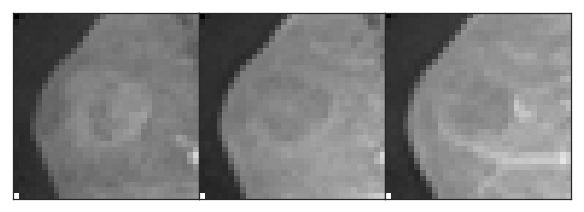

In [38]:
importlib.reload(vm)
I=vm.plot_check(2, accnums[0]+"_0", slice_frac=.5);

### Manifold

In [35]:
img_fns = [fn for fn in glob.glob(join(C.unaug_dir, "*.npy"))]

In [ ]:
%matplotlib qt
importlib.reload(vm)
vm.semiauto_label_lesions()

In [14]:
importlib.reload(mani)
dm = mani.DiseaseManifold()

In [ ]:
dm.mr_gan.generator.summary()

In [16]:
gen = dm._train_gen_encoder(inputs=['z'], outputs=['mr'])

In [17]:
def metagen(gen):
    while True:
        latent_vec, real_img = next(gen)
        batch_size = latent_vec.shape[0]
        yield latent_vec, np.ones((batch_size, 1))
mg = metagen(gen)

In [ ]:
dm.mr_gan.train(epochs=100, gen=gen)

In [ ]:
dm.mr_gan.g_train(epochs=1000, gen=gen)

In [ ]:
dm.mr_gan.generator.fit_generator(gen, 50, epochs=30);

In [ ]:
dm.mr_gan.combined.fit_generator(mg, 100, epochs=50);

### Patches for Lesion detector

In [27]:
I = np.load(join(C.full_img_dir, "4262153.npy"))

In [37]:
accnum = "4262153"
load_dir = join(C.dcm_dirs[0], accnum)
art,D = hf.load_img(join(load_dir, "nii_dir", "20s.nii.gz"))
ven,_ = hf.load_img(join(load_dir, "nii_dir", "70s.nii.gz"))
eq,_ = hf.load_img(join(load_dir, "nii_dir", "3min.nii.gz"))
I = np.stack((art, ven, eq), -1)

In [55]:
tr.rescale_img(I, [1,1,1], D).shape

(380, 380, 240, 3)

In [97]:
importlib.reload(tr)
cropIs = tr.split_img(I, D, L=100)#, target_dims=[24,24,24])

In [89]:
cropIs[-3].max()

5.942105263157892

(18, 100, 100, 100, 3)


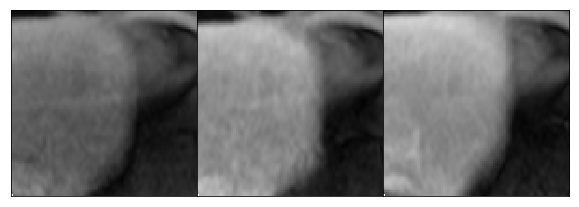

In [102]:
print(cropIs.shape)
vis.draw_slices(cropIs[15], normalize=[0,200])

### Paula radpath

In [102]:
hcc_wr = [1]*5 + [2]*4 + [3]*1
hcc_cor = [1]*18 + [2]*24 + [3]*41
n_hcc_wr = [0]*0 + [1]*2 + [2]*3 + [3]*6
n_hcc_cor = [1]*16 + [1]*22 + [2]*8 + [3]*0

scipy.stats.kruskal(n_hcc_cor, n_hcc_wr)
scipy.stats.kruskal(hcc_corr, hcc_wro)

In [ ]:
lesion_df = drm.get_lesion_df()

In [ ]:
lesion_df.loc["E101523098_3"]

In [132]:
importlib.reload(vm)
vm.save_vois_as_imgs(lesion_ids=['E105152299_0', 'E106158268_0', 'E106120112_0'] + ['E105124678_0', 'E103678771_0'] + ['E101880575_0', 'E105095742_0', 'E101895019_0', 'E101523098_3', 'E102088195_1', 'E101158768_1', 'E101449797_0'],
                     save_dir="D:\\Radpath\\screenshots-large", separate_by_cls=False)

In [109]:
importlib.reload(drm)
drm.open_dcm_folder("hcc",'E100207241')

In [92]:
for accnum in radpath_reader:
    if len(lesion_df[lesion_df["accnum"] == accnum]) > 1:
        print(accnum)

E106405787
E103020139
E102027289
E101523098


### Paula clinical vals

In [26]:
df = pd.read_csv(C.run_stats_path)
df = df[(df['hcc'] == 141) & (df['clinical_inputs'] == 9) & (df['steps_per_epoch']>100)]

In [28]:
a2 = df.loc[(df['hcc'] == 141) & (df['clinical_inputs'] == 2) & (df['steps_per_epoch']>100), "acc6cls"]

In [29]:
a9 = df.loc[(df['hcc'] == 141) & (df['clinical_inputs'] == 9) & (df['steps_per_epoch']>100), "acc6cls"]

In [36]:
scipy.stats.mannwhitneyu(a0,a2, alternative='less')

MannwhitneyuResult(statistic=46.5, pvalue=0.409355106787271)

In [18]:
[print("%.1f%%"%(x*100)) for x in (np.mean(df.acc6cls), np.std(df.acc6cls))]

73.2%
5.3%


[None, None]

### Etiology

In [71]:
df = pd.read_excel(C.coord_xls_path)
df = df[df["Include"]==1]

df.loc[df["HepC_ViralLoad"] == '299.000 (3/28/2014) ', "HepC_ViralLoad"] = 299
df.loc[df["HepB_ViralLoad"] == '<5', "HepB_ViralLoad"] = 2.5
df.loc[df["HepB_ViralLoad"] == '<20', "HepB_ViralLoad"] = 10
df.loc[df["Tumor_Dx_MRI_Accession"]=="E100209927", "Alcohol"] = -1

In [56]:
df = df.fillna(0)

In [16]:
coords_df = pd.read_excel(C.coord_xls_path, sheet_name="Lesion Coordinates")

In [17]:
for f in ["Arterial enhancement", "Washout", "Capsule"]:
    coords_df.loc[coords_df[f] == '0/0', f] = 0
    coords_df.loc[coords_df[f] == '0/1', f] = 0
    coords_df.loc[coords_df[f] == '0/3', f] = 0
    coords_df.loc[coords_df[f] == '1/3', f] = 1
    coords_df.loc[coords_df[f] == '2/3', f] = 2
    coords_df.loc[coords_df[f] == '3/3', f] = 3
    coords_df.loc[coords_df[f] == '9/3', f] = 0

In [18]:
categories = ["HBV", "HCV", "EtOH", "NASH"]

In [19]:
DF = {category: coords_df[coords_df["cls"] == category] for category in categories}

In [78]:
DF = {category: df[df["Etiology"] == category] for category in categories}

In [72]:
df.loc[df["Cirrhosis"]<0, "Cirrhosis"] = np.nan

In [73]:
df.dropna(subset=["Cirrhosis"], inplace=True)

In [76]:
df.dropna(subset=["CPS"], inplace=True)

In [ ]:
[print(d,len(DF[d])) for d in DF];

#### P-values

In [21]:
cats = list(zip(["HBV"]*3+["HCV"]*2+["EtOH"],["HCV","EtOH","NASH","EtOH","NASH","NASH"]))

In [ ]:
col = "TumorSize"#"Diameter (cm)"#"Age at Diagnosis"
for cat1, cat2 in cats:
    print(cat1, cat2, "%.3f" % \
          scipy.stats.mannwhitneyu(DF[cat1][col], DF[cat2][col]).pvalue)

print("%.4f" % scipy.stats.kruskal(*[DF[cat][col].dropna() for cat in categories])[1])

In [ ]:
#strength
for col in ["Arterial enhancement", "Washout", "Capsule"]:
    for cat1, cat2 in cats:
        print(cat1, cat2, "%.3f" % \
              scipy.stats.mannwhitneyu(DF[cat1][col], DF[cat2][col]).pvalue)

    print("%.4f" % scipy.stats.kruskal(*[DF[cat][col].dropna() for cat in categories])[1])

In [ ]:
#presence
for col in ["Arterial enhancement", "Washout", "Capsule"]:
    for cat1, cat2 in cats:
        cont_table = np.array([[sum(DF[cat1][col]==0), sum(DF[cat1][col]>0)],
                               [sum(DF[cat2][col]==0), sum(DF[cat2][col]>0)]], int)
        print(cat1, cat2, "%.3f" % \
              scipy.stats.fisher_exact(cont_table)[1])

    print("%.3f" % scipy.stats.chi2_contingency(pd.crosstab(coords_df["cls"], coords_df[col]))[1])

In [ ]:
for cat1, cat2 in cats:
    cont_table = np.array([[sum(DF[cat1]["Gender"]=="M"), sum(DF[cat1]["Gender"]=="F")],
                           [sum(DF[cat2]["Gender"]=="M"), sum(DF[cat2]["Gender"]=="F")]], int)
    print(cat1, cat2, "%.3f" % \
          scipy.stats.fisher_exact(cont_table)[1])
    
print("%.3f" % scipy.stats.chi2_contingency(pd.crosstab(df["Etiology"], df["Gender"]))[1])

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["BCLC"])
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    if "NASH" not in [cat1, cat2]:
        cont_table.drop(0, axis=1, inplace=True)
    print(cat1, cat2, "%.3f" % scipy.stats.chi2_contingency(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

In [52]:
xtab = pd.crosstab(df["Etiology"], df["CPS"])
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.chi2_contingency(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

HBV HCV 0.349
HBV EtOH 0.176
HBV NASH 0.757
HCV EtOH 0.264
HCV NASH 0.571
EtOH NASH 0.155
0.380


In [ ]:
scipy.stats.chi2_contingency(xtab)[1]

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Cirrhosis"])
xtab.drop(-1, axis=1, inplace=True)
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.fisher_exact(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["AFP>400"])
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.fisher_exact(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Portal_Invasion"])
xtab = xtab[[0,1]]
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.fisher_exact(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

In [100]:
df["Unifocal"] = df["NumberLesions"] == 1

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Unifocal"])
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.fisher_exact(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

#### graphing

In [27]:
def set_g_bar(g, save_path):
    g.set(yticks=[0.,.2,.4,.6,.8,1.], ylim=(0.,1.));
    """topbar = plt.Rectangle((0,0),1,1,fc="#C3C3C3", edgecolor = 'none')
    midbar = plt.Rectangle((0,0),1,1,fc='#A3A3A3',  edgecolor = 'none')
    bottombar = plt.Rectangle((0,0),1,1,fc='#737373',  edgecolor = 'none')
    l = plt.legend([bottombar, midbar, topbar],
                   ['High Lipiodol', 'Medium Lipiodol', 'Low Lipiodol'], loc='upper left')#, ncol=2, prop={'size':16})
    l.draw_frame(False)"""
    
    for gax in g.axes[0]:
        gax.set_xlabel("")
        gax.set_ylabel("")
        #gax.tick_params('x',width=0)
        gax.set_xticks([], minor=False)
        gax.set_yticks([], minor=False)
        plt.setp(gax.patches, linewidth=1, edgecolor='k')
        
    g.set_titles(visible=False)
    #g.axes[0][0].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
    
    sns.despine(top=True, right=True, left=True)
    g.fig.subplots_adjust(left=.2, top=.95)
    
    #g.fig.tight_layout(w_pad=1)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, dpi=150, pad_inches=0, transparent=True) #, width=5
    plt.close()

In [ ]:
plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
kwargs = {"data":df, "size":3, "kind":"bar", "color":"#C3C3C3", "legend":False}
sns.set(style="ticks", font_scale=1.7)
g = sns.factorplot(x="Etiology", y="Age at Diagnosis", order=categories, aspect=1.7, **kwargs)
g.set(yticks=[40,50,60,70,80], ylim=(40,80));
for gax in g.axes[0]:
    gax.set_xlabel("")
    gax.set_ylabel("")
g.fig.savefig("D:\\Etiology\\graphs\\age.png", pad_inches=0, transparent=True) #, width=5

In [ ]:
plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
kwargs = {"data":df, "size":3, "kind":"bar", "color":"#C3C3C3", "legend":False}
sns.set(style="ticks", font_scale=1.7)
g = sns.factorplot(x="Etiology", y="TumorSize", order=categories, aspect=1.7, **kwargs)
g.set(yticks=[0,25,50,75], ylim=(0,75));
for gax in g.axes[0]:
    gax.set_xlabel("")
    gax.set_ylabel("")
g.fig.savefig("D:\\Etiology\\graphs\\lesionsize.png", pad_inches=0, transparent=True) #, width=5

In [ ]:
coords_df["Diameter (cm)"] = coords_df["Diameter (cm)"] * 10

In [ ]:
plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
kwargs = {"data":coords_df, "size":3, "kind":"bar", "color":"#C3C3C3", "legend":False}
sns.set(style="ticks", font_scale=1.7)
g = sns.factorplot(x="cls", y="Diameter (cm)", order=categories, aspect=1.7, **kwargs)
g.set(yticks=[0,20,40,60], ylim=(0,60));
for gax in g.axes[0]:
    gax.set_xlabel("")
    gax.set_ylabel("")
g.fig.savefig("D:\\Etiology\\graphs\\lesionsize_all.png", pad_inches=0, transparent=True) #, width=5

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Gender"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab["M"], width=.8)#, yerr=xtab["M"]
p2 = plt.bar(range(4), xtab["F"], width=.8, bottom=xtab["M"])
plt.legend((p2, p1), ('Female', 'Male'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\gender.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["BCLC"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p = [plt.bar(range(4), xtab["D"], width=.8)]
p.append(plt.bar(range(4), xtab["C"], width=.8, bottom=xtab["D"]))
p.append(plt.bar(range(4), xtab["B"], width=.8, bottom=xtab["D"]+xtab["C"]))
p.append(plt.bar(range(4), xtab["A"], width=.8, bottom=xtab["D"]+xtab["C"]+xtab["B"]))
p.append(plt.bar(range(4), xtab[0], width=.8, bottom=xtab["D"]+xtab["C"]+xtab["B"]+xtab["A"]))
plt.legend(p[::-1], ('D', 'C', 'B', 'A', '0')[::-1], bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\bclc.png", bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["CPS"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p = [plt.bar(range(4), xtab["C"], width=.8)]
p.append(plt.bar(range(4), xtab["B"], width=.8, bottom=xtab["C"]))
p.append(plt.bar(range(4), xtab["A"], width=.8, bottom=xtab["C"]+xtab["B"]))
plt.legend(p[::-1], ('A', 'B', 'C'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\cps.png", bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Cirrhosis"]).drop(-1,axis=1).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab[0], width=.8)
p2 = plt.bar(range(4), xtab[1], width=.8, bottom=xtab[0])
plt.legend((p2, p1), ('Cirrhosis', 'No Cirrhosis'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\cirrhosis.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
df["AFP>400"] = df["AFP"]>400
xtab = pd.crosstab(df["Etiology"], df["AFP>400"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab[0], width=.8)
p2 = plt.bar(range(4), xtab[1], width=.8, bottom=xtab[0])
plt.legend((p2, p1), ('>400ng/mL', '<400ng/mL'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\afp.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Portal_Invasion"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab[0], width=.8)
p2 = plt.bar(range(4), xtab[1], width=.8, bottom=xtab[0])
plt.legend((p2, p1), ('Invasion', 'No Invasion'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\invasion.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
df["Multifocal"] = df["NumberLesions"]!=1
xtab = pd.crosstab(df["Etiology"], df["Multifocal"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab[False], width=.8)
p2 = plt.bar(range(4), xtab[True], width=.8, bottom=xtab[False])
plt.legend((p2, p1), ('Multifocal', 'Unifocal'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\multifocal.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
for f in ["Arterial enhancement", "Washout", "Capsule"]:
    plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
    kwargs = {"data":coords_df, "size":3, "kind":"bar", "color":"#C3C3C3", "legend":False}
    sns.set(style="ticks", font_scale=1.7)
    g = sns.factorplot(x="cls", y=f, order=categories, aspect=1.7, **kwargs)
    g.set(yticks=[0,1,2,3], ylim=(0,3));
    for gax in g.axes[0]:
        gax.set_xlabel("")
        gax.set_ylabel("")
    g.fig.savefig("D:\\Etiology\\graphs\\%s.png" % f, pad_inches=0, transparent=True) #, width=5

In [145]:
coords_df.dropna(subset=["Arterial enhancement", "Washout", "Capsule"], inplace=True)

In [ ]:
for f in ["Arterial enhancement", "Washout", "Capsule"]:
    coords_df[f+"_Presence"] = coords_df[f]>0
    xtab = pd.crosstab(coords_df["cls"], coords_df[f+"_Presence"]).apply(lambda r: r/r.sum(), axis=1)
    xtab = xtab.loc[categories]

    plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
    p1 = plt.bar(range(4), xtab[False], width=.8)
    p2 = plt.bar(range(4), xtab[True], width=.8, bottom=xtab[False])
    plt.legend((p2, p1), ('Present', 'Not present'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
    plt.axes().set_yticklabels(["0%", "50%", "100%"]);
    plt.xticks(range(4), xtab.index)
    plt.axes().set_yticks([0,.5,1], minor=False)
    sns.despine(top=True, right=True)
    ax = plt.axes()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.savefig("D:\\Etiology\\graphs\\%s_presence.png" % f, dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

#### etc

In [66]:
coords_df = pd.read_excel(xls_path, sheetname=1)

In [46]:
importlib.reload(vm)
vm.save_segs_as_imgs()

In [57]:
importlib.reload(vm)
vm.remove_lesion_id("5276207")

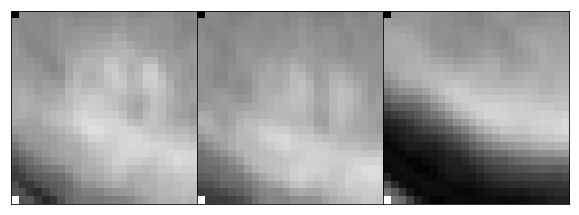

In [23]:
importlib.reload(vm)
vm.plot_check(1,"4262153_1");

In [62]:
importlib.reload(vm)
vm.save_seg_set(unaug=False, num_cores=2, overwrite=False)